###  3.0 A/B Testing

3.1 Setup:  Libraries and Data Initial setup includes loading all necessary libraries and importing the dataset.

3.2 A/B Testing:  Bayesian statistics applied.  With 100% probability the exposed users were 2.5 times more likely to convert than the non-exposed.

### 3.1 Setup

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install arviz

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
from scipy.stats import beta

In [ ]:
# Sample upload of data
# Saved from previous notebook
df=pd.read_csv('raw_data.csv')
df.head()

### 3.2 A/B Statistical Testing

In [ ]:
# A/B Test result using Z-statistic

df_conversion=df_filtered[['exposure', 'conversion']].reset_index(drop=True)

exposed_converted = df_conversion[(df_conversion['exposure'] == 1) & (df_conversion['conversion'] == 1)].shape[0]
not_exposed_converted = df_conversion[(df_conversion['exposure'] == 0) & (df_conversion['conversion'] == 1)].shape[0]


exposed_total = df_conversion[df_conversion['exposure'] == 1].shape[0]
not_exposed_total = df_conversion[df_conversion['exposure'] == 0].shape[0]

counts = np.array([exposed_converted, not_exposed_converted])
nobs = np.array([exposed_total, not_exposed_total])

stat, pval = proportions_ztest(count=counts, nobs=nobs)

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {pval:.4f}")

if pval < 0.05:
    print("Result: Statistically significant difference in conversion.")
else:
    print("Result: No statistically significant difference in conversion.")
print(f"Conversion rate (exposed): {exposed_converted / exposed_total:.4f}")
print(f"Conversion rate (not exposed): {not_exposed_converted / not_exposed_total:.4f}")

Z-statistic: 138.1808
P-value: 0.0000
Result: Statistically significant difference in conversion.
Conversion rate (exposed): 0.1301
Conversion rate (not exposed): 0.0371


In [ ]:
# Use 95% confidence inervals to calculate ranges of conversion for exposed and not exposed groups

exposed = df_conversion[df_conversion['exposure'] == 1]
not_exposed = df_conversion[df_conversion['exposure'] == 0]

exposed_conv_rate = exposed['conversion'].mean()
not_exposed_conv_rate = not_exposed['conversion'].mean()

exposed_n = len(exposed)
not_exposed_n = len(not_exposed)

# Standard error for proportions
se_exposed = np.sqrt(exposed_conv_rate * (1 - exposed_conv_rate) / exposed_n)
se_not_exposed = np.sqrt(not_exposed_conv_rate * (1 - not_exposed_conv_rate) / not_exposed_n)

# 95% confidence intervals
z = stats.norm.ppf(0.975)  # 1.96 for 95% CI
ci_exposed = (exposed_conv_rate - z * se_exposed, exposed_conv_rate + z * se_exposed)
ci_not_exposed = (not_exposed_conv_rate - z * se_not_exposed, not_exposed_conv_rate + z * se_not_exposed)

print("Conversion Rate (Exposed):", round(exposed_conv_rate, 4), "CI:", ci_exposed)
print("Conversion Rate (Not Exposed):", round(not_exposed_conv_rate, 4), "CI:", ci_not_exposed)

Conversion Rate (Exposed): 0.1301 CI: (np.float64(0.1285654669480112), np.float64(0.13170493502843916))
Conversion Rate (Not Exposed): 0.0371 CI: (np.float64(0.036574298926094824), np.float64(0.03764755687204186))


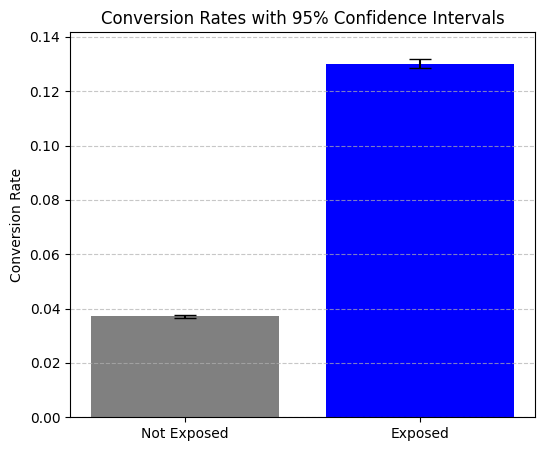

In [ ]:
# Plot conversion rates of both groups with error bars

labels = ['Not Exposed', 'Exposed']
rates = [not_exposed_conv_rate, exposed_conv_rate]
errors = [z * se_not_exposed, z * se_exposed]  # error bars = half-width of CI

plt.figure(figsize=(6, 5))
plt.bar(labels, rates, yerr=errors, capsize=8, color=['gray', 'blue'])
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates with 95% Confidence Intervals')
plt.ylim(0, max(rates) + max(errors) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

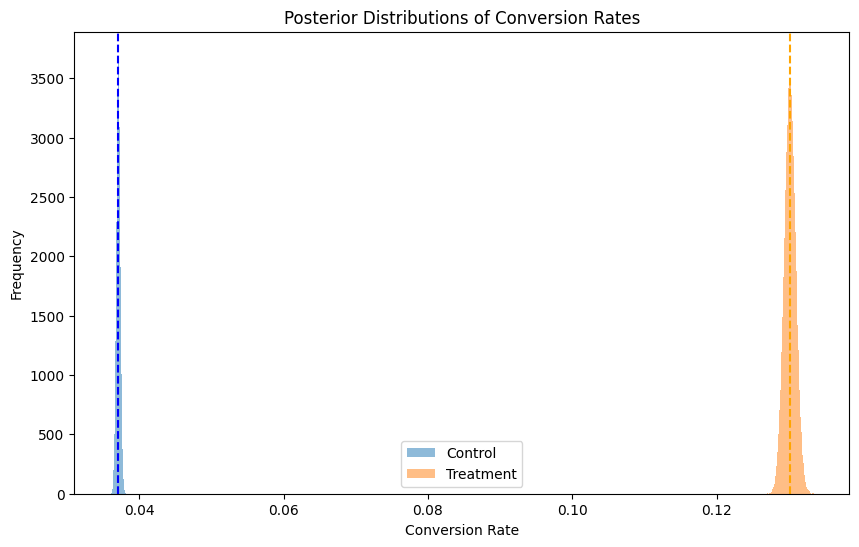

Probability treatment is better: 1.0000
Estimated relative lift: 250.68%


In [ ]:
# Plot posterior distributions for conversion for exposed and not exposed groups

control_conversions=df_filtered[(df_filtered['exposure']==0)&(df_filtered['conversion']==1)].shape[0]
control_total=df_filtered[df_filtered['exposure']==0].shape[0]

treatment_conversions=df_filtered[(df_filtered['exposure']==1)&(df_filtered['conversion']==1)].shape[0]
treatment_total=df_filtered[df_filtered['exposure']==1].shape[0]

control_posterior=beta(control_conversions+1,control_total-control_conversions+1)
treatment_posterior=beta(treatment_conversions+1,treatment_total-treatment_conversions+1)

samples = 100000
control_samples = control_posterior.rvs(samples)
treatment_samples = treatment_posterior.rvs(samples)

# Probability that treatment is better
prob_treatment_better = (treatment_samples > control_samples).mean()
lift = ((treatment_samples - control_samples) / control_samples).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(control_samples, bins=100, alpha=0.5, label='Control')
plt.hist(treatment_samples, bins=100, alpha=0.5, label='Treatment')
plt.axvline(control_samples.mean(), color='blue', linestyle='--')
plt.axvline(treatment_samples.mean(), color='orange', linestyle='--')
plt.legend()
plt.title('Posterior Distributions of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')
plt.show()

print(f"Probability treatment is better: {prob_treatment_better:.4f}")
print(f"Estimated relative lift: {lift * 100:.2f}%")

The results of A/B testing indicate that there is a statistically significant difference in conversion rates for exposed vs non exposed users. The Bayesian testing showed a 100% probability that the treated users were 2.5 times more likely to convert.